Importing libraries

In [1]:
# importing the required libraries
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

c:\Users\prakh\anaconda3\envs\learnml\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\prakh\anaconda3\envs\learnml\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

KeyboardInterrupt: 

In [ ]:
# checking pytorch version
print(torch.__version__)

2.2.0


In [ ]:
import torchvision
# checking if cuda is available
torch.cuda.is_available()

True

In [ ]:
# setting the device to cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset download and setup

In [34]:
# File handling
current_path = os.getcwd()
new_path = os.path.join(current_path, 'Cropped_final\Cropped_final')
os.chdir(new_path)
for i in os.listdir():
    print(i)

amur_leopard
amur_tiger
birds
black_bear
brown_bear
dog
people
roe_deer
sika_deer
wild_boar


Dataset Class

In [35]:
class RussianWildLifeDataset(Dataset):
  def __init__(self, root_dir, transform):
    self.transform = transform
    self.root_dir = root_dir
    self.classes = os.listdir(self.root_dir)
    self.classes.sort()
    self.class_index_mapping = dict(zip(range(len(self.classes)), self.classes))
    self.__load_data__()

  def __load_data__(self):
    self.images_filenames = []
    self.labels = []
    for i in range(len(self.class_index_mapping)):
      # go to the class directory
      os.chdir(new_path)
      class_path = os.path.join(self.root_dir, self.class_index_mapping[i])
      for image in os.listdir(class_path):
        self.images_filenames.append(os.path.join(class_path, image))
        self.labels.append(i)

  def get_class_name(self, label):
    return self.class_index_mapping[label]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = im.open(self.images_filenames[idx])
    label = self.labels[idx]
    if (self.transform):
      image = self.transform(image)
    sample = {'image': image, 'label': label}
    return sample

Transformations

In [36]:
composed_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Dataset and DataLoaders

In [37]:
dataset = RussianWildLifeDataset(new_path, composed_transform)
all_labels = [sample['label'] for sample in dataset]
train_data, testing_data, train_labels, testing_labels = train_test_split(dataset, all_labels, train_size=0.7, stratify=all_labels, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(testing_data, testing_labels, train_size=0.33, stratify=testing_labels, random_state=42)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

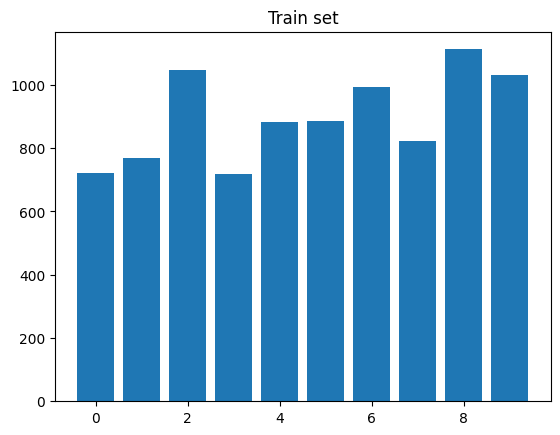

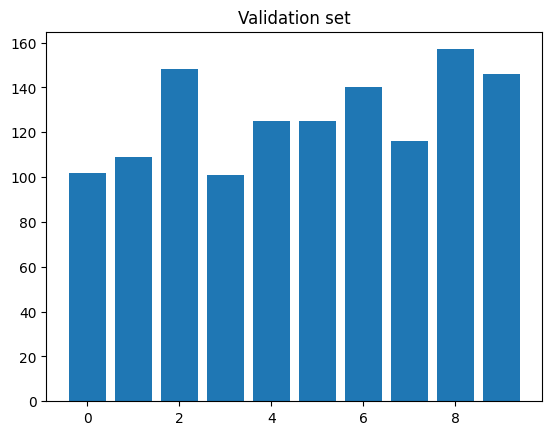

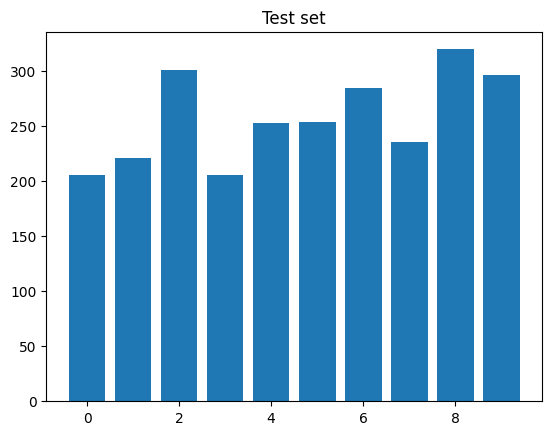

In [ ]:
def plot_distribution(data, title):
  labels = [sample['label'] for sample in data]
  unique, counts = np.unique(labels, return_counts=True)
  plt.bar(unique, counts)
  plt.title(title)
  plt.show()

plot_distribution(train_data, 'Train set')
plot_distribution(val_data, 'Validation set')
plot_distribution(test_data, 'Test set')

In [ ]:
print(os.getcwd())
os.chdir("..")
os.chdir("..")
print(os.getcwd())

c:\Users\prakh\OneDrive\Documents\GitHub\CV_Assignments\A1


WandB Setup


In [ ]:
import wandb
wandb.login()

In [ ]:
model_config = dict(
    epochs=10,
    classes=10,
    kernels=[3, 3, 3],
    features=[32, 64, 128],
    batch_size=16,
    optimizer="Adam",
    learning_rate=0.001,
    dataset="Russian WildLife Dataset",
    architecture="ConvNet", 
    weight_initialisation="Default")

In [ ]:
run_num = 1
wandb.init(
    project = "Computer_Vision_A1",
    name = f"Q2_A_Experiment_{run_num}",
    config = model_config,
)

Visualizing Training Data

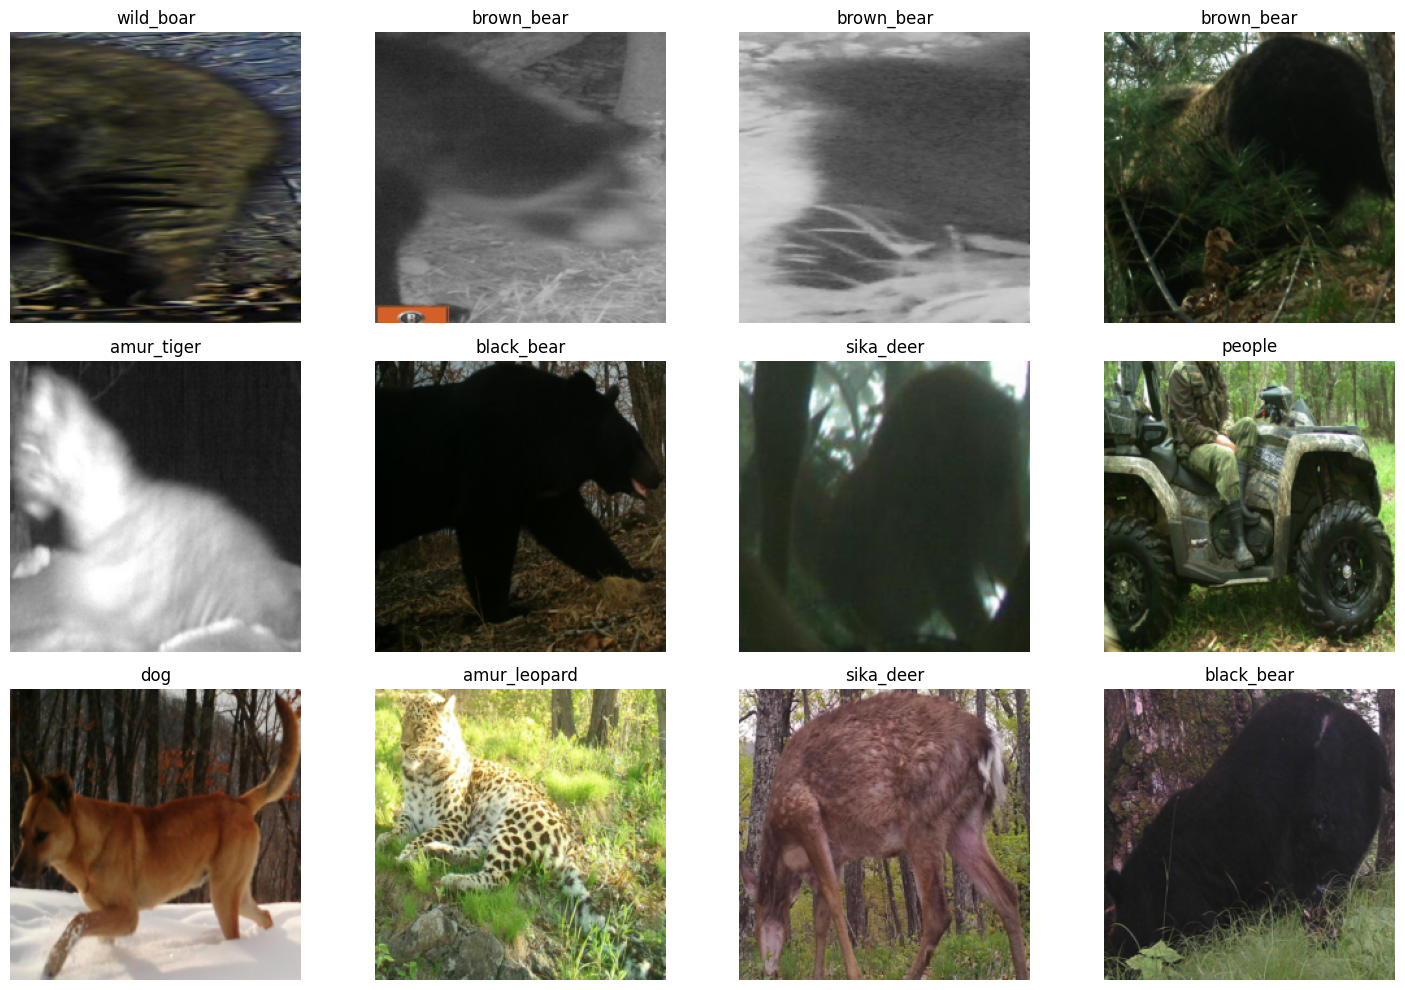

In [ ]:
num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= train_size:
            break
        sample = train_data[idx]
        axs[i, j].set_title(f"{dataset.get_class_name(sample['label'])}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = transforms.ToPILImage()((((sample['image']+1)/2) * 255).squeeze().to(torch.uint8))
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()

Visualizing Validation Data


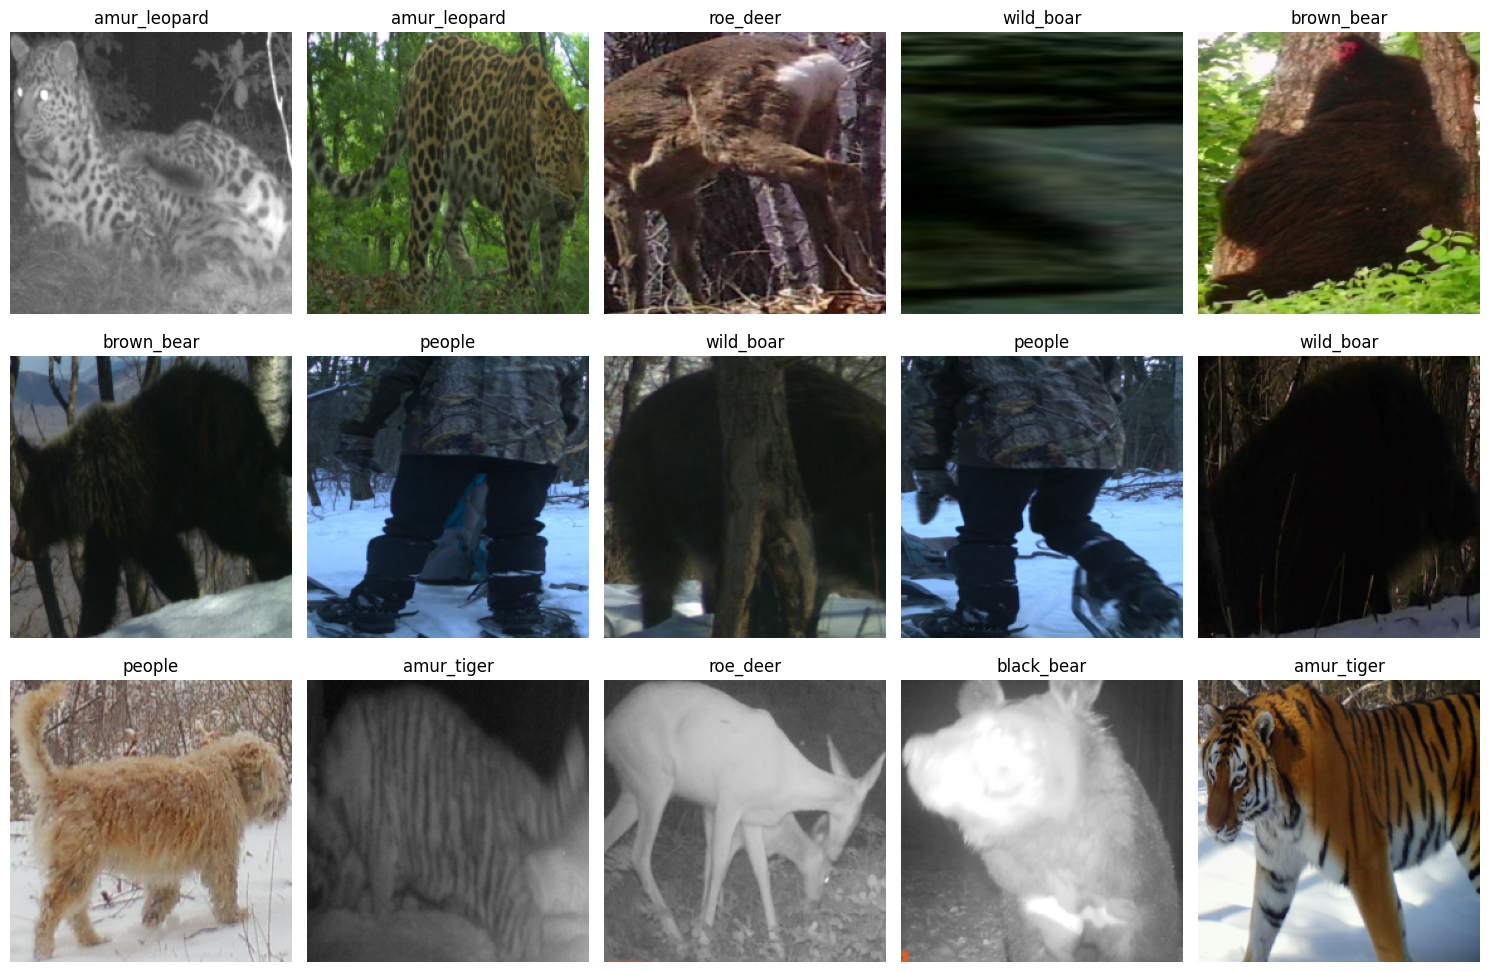

In [ ]:
num_rows = 3
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= len(val_data):
            break
        sample = val_data[idx]
        axs[i, j].set_title(f"{dataset.get_class_name(sample['label'])}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = transforms.ToPILImage()((((sample['image']+1)/2) * 255).squeeze().to(torch.uint8))
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        # First Convolutional Layer
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=4)
    )
    self.conv_layer2 = nn.Sequential(
        # Second Convolutional Layer
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_layer3 = nn.Sequential(
        # Third Convolutional Layer
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fully_connected = nn.Sequential(
        nn.Linear(128*14*14, 10),
        nn.ReLU()
    )
    self.Softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = torch.flatten(x, 1)
    logits = self.fully_connected(x)
    return logits

  def softmax(self, x):
    x = self.Softmax(x)
    return x

model = ConvNet()

In [ ]:
model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# move the model to the gpu
model.to(device)

In [ ]:
def loss_acc_calc(dataloader):
  with torch.no_grad():
    correct, total, loss = 0, 0, 0.0
    for i, sample in enumerate(dataloader, 0):
      images = sample['image']
      labels = sample['label']
      forwards = model.forward(images)
      logits = model.softmax(forwards)
      preds = torch.argmax(logits, dim=1)
      correct += torch.eq(preds, labels).sum().item()
      total += labels.size(0)
      loss_val = loss_fn(forwards, labels)
      loss += loss_val.item()
  return correct, total, loss

In [ ]:
wandb.watch(model)

In [ ]:
def train_model(model, model_config, loss_fn, optimizer, train_dataloader, val_dataloader):
    running_loss = 0.0
    for epoch in range(model_config['epoch']):
        for i, sample in enumerate(train_dataloader, 0):
            inputs = sample['image']
            labels = sample['label']
            # zero the gradients before backprop
            optimizer.zero_grad()
            # forward pass
            logits = model.forward(inputs)
            loss = loss_fn(logits, labels)
            # backward pass
            loss.backward()
            optimizer.step()
            minibatch_loss = loss.item()
            running_loss += minibatch_loss
            # logging the minibatch after every batch, and running loss after every 100 minibatches
            wandb.log({'minibatch_loss': minibatch_loss})
            if (i%100==0):
                wandb.log({'running_loss': running_loss / 100})
                running_loss = 0.0
        # log the training accuracy and loss
        correct, total, loss = loss_acc_calc(train_dataloader)
        wandb.log({'train_loss': loss / len(train_dataloader), 'train_accuracy': (correct / total) * 100.0})
        # log the validation accuracy and loss
        correct, total, loss = loss_acc_calc(val_dataloader)
        wandb.log({'val_loss': loss / len(val_dataloader), 'val_accuracy': (correct / total) * 100.0})
    # save the model after training
    torch.save(model.state_dict(), f"A1_Q2_Experiment_{run_num}.pth")
    return model

In [ ]:
# training the model 
model = train_model(model, model_config, loss_fn, optimizer, train_dataloader, val_dataloader)

In [ ]:
def evaluation_metris_calc(dataloader):
    y_true = []
    y_pred = []
    for i, sample in enumerate(dataloader, 0):
        images = sample['image']
        labels = sample['label']
        forwards = model.forward(images)
        logits = model.softmax(forwards)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

In [ ]:
# testing the model 
correct, total, loss = loss_acc_calc(test_dataloader)
print(f"Test Accuracy: {(correct / total) * 100.0}%")
wandb.log({'test_accuracy': (correct / total) * 100.0})
# calculate the metrics
y_true, y_pred = evaluation_metris_calc(test_dataloader)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
# logging the metrics onto wandb
confusion_matrix = wandb.plot.confusion_matrix(y_true=y_true, preds=y_pred, class_names=dataset.classes)
wandb.run.summary["test_accuracy"] = (correct / total) * 100.0
wandb.run.summary["f1_score"] = f1
wandb.run.summary["precision"] = precision
wandb.run.summary["recall"] = recall

In [ ]:
def misclassified_images(dataloader):
    misclassified = []
    for i, sample in enumerate(dataloader, 0):
        images = sample['image']
        labels = sample['label']
        forwards = model.forward(images)
        logits = model.softmax(forwards)
        preds = torch.argmax(logits, dim=1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i], labels[i], preds[i]))
    return misclassified

In [ ]:
misclassified = misclassified_images(test_dataloader)
num_rows = 10
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 30))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= len(misclassified):
            break
        image, true_label, pred_label = misclassified[idx]
        axs[i, j].set_title(f"True: {dataset.get_class_name(true_label)}, Pred: {dataset.get_class_name(pred_label)}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = transforms.ToPILImage()((((image+1)/2) * 255).squeeze().to(torch.uint8))
        axs[i, j].imshow(image)

In [ ]:
model.to_onxx()
wandb.save("Model.onxx")